# Import Necessary Libraries
This section imports essential libraries needed for the project. `numpy` and `pandas` are used for data manipulation, `tensorflow` for building and training the neural network model, and various

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/GW_DA2/Churn_Modelling.csv"

Mounted at /content/drive


# Load the Dataset
This step involves loading the dataset from a CSV file into a pandas DataFrame. The dataset includes various features of bank customers and a target variable indicating whether the customer exited the bank (churned). We separate the features (X) and the target variable (y) for further processing.


In [3]:
dataset = pd.read_csv(file_path)
X = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values

In [4]:
dataset.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


# Encode Categorical Data
Machine learning models require numerical input, so we need to encode categorical variables. Here, we use Label Encoding for the "Gender" column, converting male and female to 0 and 1, respectively. For the "Geography" column, we apply One Hot Encoding to create binary columns for each category. This preprocessing step is crucial for converting categorical data into a format that can be provided to the model for training.


In [5]:
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])

In [6]:
X.shape

(10000, 10)

# Encode the Geography field Data using OneHotEncoder()
ColumnTransformer: This class enables the application of different transformations to different columns of a dataset within a single step. It takes the following key arguments:
transformers: A list of triplets (name, transformer, columns) where:
Name ('myencoder'): A user-defined identifier for the transformation step.
Transformer (OneHotEncoder()): Specifies the transformation to apply. Here, OneHotEncoder is used to encode categorical features as a one-hot numeric array.
Columns ([1]): Indicates the index(es) of the columns to which the transformer should be applied. In this case, it targets the column at index 1 for one-hot encoding.
remainder='passthrough': Determines the handling of the columns not explicitly selected for transformation. Setting it to 'passthrough' means these columns will be left unchanged and appended to the output of the transformed columns.
fit_transform: This method first fits the ColumnTransformer to the data, learning any necessary parameters (e.g., categories in a categorical column for one-hot encoding), and then transforms the data according to the specified transformations.
np.array: Converts the output to a numpy array. This conversion is essential when dealing with sparse matrices (the default output type for many transformers like OneHotEncoder) to ensure compatibility with estimators or operations that require dense formats.

In [7]:
ct = ColumnTransformer(transformers=[('myencoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X), dtype='float32')

In [8]:
X.shape

(10000, 12)

# Split the Dataset
We split the dataset into training, validation, and test sets to evaluate the model's performance accurately. The training set is used to train the model, the validation set to tune hyperparameters and prevent overfitting, and the test set to evaluate the model's generalization performance on unseen data.

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [11]:
print("the training size is \n",X_train.shape)
print("the validation size is \n",X_val.shape)
print("the test size is \n",X_test.shape)

the training size is 
 (6000, 12)
the validation size is 
 (2000, 12)
the test size is 
 (2000, 12)


# Feature Scaling
Feature scaling standardizes the range of input features, ensuring that no single feature dominates others during model training. This step improves the convergence of the model and is performed using StandardScaler, which scales features to have a mean of 0 and a variance of 1.

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [12]:
X_train.shape[1]

12

In [13]:
X_train[:1]

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 5.7900000e+02,
        1.0000000e+00, 4.3000000e+01, 2.0000000e+00, 1.4584381e+05,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.9840238e+05]],
      dtype=float32)

# Initialize the Artificial Neural Network (ANN)
Here, we initialize our ANN model as a sequence of layers using TensorFlow's Sequential API. We explicitly define an input layer to match the shape of our features, followed by hidden layers with ReLU activation functions for non-linearity, and finally, an output layer with a sigmoid activation function for binary classification.

In [60]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
# ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
# ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the ANN
Compiling the model involves specifying the optimizer, loss function, and metrics for evaluation. We use the Adam optimizer, binary crossentropy as the loss function for binary classification, and accuracy as the metric to evaluate model performance.

In [61]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping
Early stopping is a regularization method used to prevent overfitting by stopping the training process if the model's performance on the validation set does not improve for a specified number of epochs. This technique allows us to retain the best model without unnecessary additional training.

In [58]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)

# Train the ANN
This step involves training the artificial neural network on the training data. We also validate its performance on the validation set to monitor and prevent overfitting. The `callbacks` parameter is used to implement early stopping, which halts training when the validation loss ceases to decrease, thus ensuring we don't overfit on the training data.

In [62]:
history = ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100  # Set to a higher number since early stopping may halt training early
    # callbacks=[early_stopping]
)

Epoch 1/100
188/188 [==============================] - 2s 4ms/step - loss: 4729.6040 - accuracy: 0.7210 - val_loss: 2198.5706 - val_accuracy: 0.7945
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 700.3154 - accuracy: 0.6942 - val_loss: 113.5598 - val_accuracy: 0.5785
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 77.5328 - accuracy: 0.6740 - val_loss: 68.4224 - val_accuracy: 0.7945
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 32.5992 - accuracy: 0.6858 - val_loss: 47.5452 - val_accuracy: 0.7940
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 22.1185 - accuracy: 0.7017 - val_loss: 25.3758 - val_accuracy: 0.7065
Epoch 6/100
188/188 [==============================] - 1s 3ms/step - loss: 16.7591 - accuracy: 0.6975 - val_loss: 27.4773 - val_accuracy: 0.4320
Epoch 7/100
188/188 [==============================] - 1s 3ms/step - loss: 18.2963 - accuracy: 0.6815 - val_loss: 7.1731 - v

In [ ]:
#test_loss, test_accuracy = ann.evaluate(X_test, y_test, verbose=0)

# Predicting the Test Set Results
After training the model, we use it to predict the outcomes on the test set. This step evaluates the model's performance on data it hasn't seen during training, providing insight into how well the model generalizes to new, unseen data.

In [49]:
y_pred = ann.predict(X_test)
y_pred_labels = (y_pred > 0.5)
test_accuracy = accuracy_score(y_test, y_pred_labels)

63/63 [==============================] - 0s 1ms/step


In [50]:
# Check if early stopping was triggered
if early_stopping.stopped_epoch > 0:
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience
else:
    best_epoch = len(history.history['loss']) - 1  # Use the last epoch as the best one

# Print the metrics
print('Training Loss', history.history['loss'][best_epoch])
print('Validation Loss', history.history['val_loss'][best_epoch])
print('Training Accuracy', history.history['accuracy'][best_epoch])
print('Validation Accuracy', history.history['val_accuracy'][best_epoch])
print('Test Accuracy', test_accuracy)
print('Epoch Stopped', best_epoch + 1)  # epochs are zero-indexed, but we report them starting from 1


Training Loss 0.5066229104995728
Validation Loss 0.5087746977806091
Training Accuracy 0.7985000014305115
Validation Accuracy 0.7950000166893005
Test Accuracy 0.791
Epoch Stopped 4


# Making the Confusion Matrix
The confusion matrix is a tool used to visualize the performance of an algorithm. It shows the number of correct and incorrect predictions made by the model, categorized by the actual classifications. This, along with the accuracy score, gives us a clear picture of the model's performance.

In [51]:
cm = confusion_matrix(y_test, y_pred_labels)
print(cm)


[[1582    0]
 [ 418    0]]


#Printing Model Parameters

In [23]:
# Print out the weights and biases of each layer
for layer in ann.layers:
    weights, biases = layer.get_weights()
    print(f"Weights for layer {layer.name}: {weights}")
    print(f"Biases for layer {layer.name}: {biases}")

Weights for layer dense: [[ 0.44241348  0.46438515 -0.44262585 -0.6423238   0.31876346 -0.26390964]
 [ 0.34705424  0.47720385  0.2715513  -0.30750546 -0.1180999  -0.2894307 ]
 [ 0.05453467 -0.11675188  0.40077817 -0.19317496  0.72207475  0.41854733]
 [-0.11482644 -0.2765726  -0.72417873 -0.67555094  0.38178688  0.02101201]
 [-0.08434652 -0.15316856 -0.02128634 -0.29849657  0.02350819  0.25590318]
 [ 0.00609593  0.5352658  -0.307942   -0.44285166  0.3828317  -0.07622343]
 [-0.02312111 -0.18431157 -0.51276577 -0.17643352 -0.25606194  0.13397932]
 [ 0.34235474 -0.03864253  0.33362332 -0.47756657 -0.10920116 -0.30895662]
 [ 0.37952492  0.24057364 -0.26717928  0.35286325  0.3192139   0.22249514]
 [ 0.06925144  0.3424397   0.12583499 -0.11870202 -0.58651555  0.39260578]
 [ 0.321261    0.49299634  0.29937458 -0.6967447   0.58589077  0.3239138 ]
 [-0.43793577 -0.5625649  -0.4133651   0.24492112 -0.3809059  -0.2849496 ]]
Biases for layer dense: [-0.12323435  0.         -0.14817764 -0.22396067 -

#Save the Model

In [24]:
ann.save('model_representation.keras')

Plot Model Training and Validation Loss

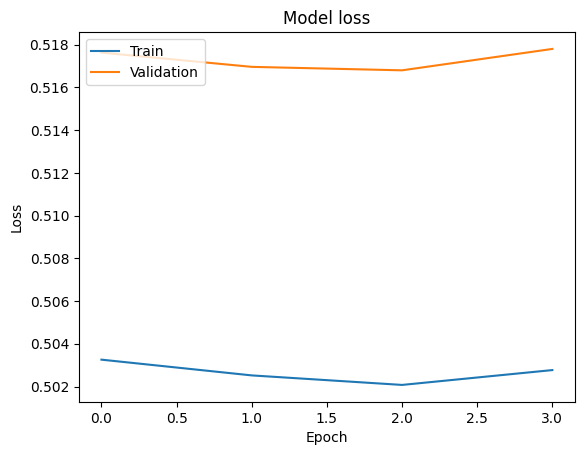

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
